# NoisePy SCEDC Tutorial

Noisepy is a python software package to process ambient seismic noise cross correlations. This tutorial aims to introduce the use of noisepy for a toy problem on the SCEDC data. It can be ran locally or on the cloud.


The data is stored on AWS S3 as the SCEDC Data Set: https://scedc.caltech.edu/data/getstarted-pds.html



First, we install the noisepy-seis package

In [ ]:
# Uncomment and run this line if the environment doesn't have noisepy already installed:
# ! pip install noisepy-seis 

__Warning__: NoisePy uses ```obspy``` as a core Python module to manipulate seismic data. If you use Google Colab, restart the runtime now for proper installation of ```obspy``` on Colab.

## Import necessary modules

Then we import the basic modules

In [42]:
from noisepy.seis import cross_correlate, stack, plotting_modules, __version__       # noisepy core functions
from noisepy.seis.asdfstore import ASDFCCStore, ASDFStackStore          # Object to store ASDF data within noisepy
from noisepy.seis.scedc_s3store import SCEDCS3DataStore, channel_filter # Object to query SCEDC data from on S3
from noisepy.seis.datatypes import ConfigParameters                     # Main configuration object
from noisepy.seis.channelcatalog import XMLStationChannelCatalog        # Required stationXML handling object
import os
from datetime import datetime
from datetimerange import DateTimeRange


from noisepy.seis.plotting_modules import plot_all_moveout

print(f"Using NoisePy version {__version__}")

path = "./scedc_data" 

os.makedirs(path, exist_ok=True)
cc_data_path = os.path.join(path, "CCF")
stack_data_path = os.path.join(path, "STACK")
S3_STORAGE_OPTIONS = {"s3": {"anon": True}}

Using NoisePy version 0.9.72.dev12


We will work with a single day worth of data on SCEDC. The continuous data is organized with a single day and channel per miniseed (https://scedc.caltech.edu/data/cloud.html). For this example, you can choose any year since 2002. We will just cross correlate a single day.

In [43]:
# SCEDC S3 bucket common URL characters for that day.
S3_DATA = "s3://scedc-pds/continuous_waveforms/"
# timeframe for analysis
start = datetime(2002, 1, 2)
end = datetime(2002, 1, 20)
range = DateTimeRange(start, end)
print(range)

2002-01-02T00:00:00 - 2002-01-20T00:00:00


The station information, including the instrumental response, is stored as stationXML in the following bucket

In [44]:
S3_STATION_XML = "s3://scedc-pds/FDSNstationXML/CI/"            # S3 storage of stationXML


## Ambient Noise Project Configuration

We prepare the configuration of the workflow by declaring and storing parameters into the ``ConfigParameters()`` object and/or editing the ``config.yml`` file.


In [45]:
# Initialize ambient noise workflow configuration
config = ConfigParameters() # default config parameters which can be customized


Customize the job parameters below:

In [46]:

config.acorr_only = False  # only perform auto-correlation or not
config.xcorr_only = True  # only perform cross-correlation or not

config.inc_hours = 24 # INC_HOURS is used in hours (integer) as the 
        #chunk of time that the paralelliztion will work.
        # data will be loaded in memory, so reduce memory with smaller 
        # inc_hours if there are over 400+ stations.
        # At regional scale for SCEDC, we can afford 20Hz data and inc_hour 
        # being a day of data.

 
# pre-processing parameters
config.samp_freq= 20  # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 3600.0  # (float) basic unit of data length for fft (sec)
config.step= 1800.0  # (float) overlapping between each cc_len (sec)

config.ncomp = 3  # 1 or 3 component data (needed to decide whether do rotation)

config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
      # If True, the stationXML file is assumed to be provided.
config.rm_resp= "inv"  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',


############## NOISE PRE-PROCESSING ##################
config.freqmin,config.freqmax = 0.05,2.0  # broad band filtering of the data before cross correlation
config.max_over_std  = 10  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

################### SPECTRAL NORMALIZATION ############
config.freq_norm= "rma"  # choose between "rma" for a soft whitening or "no" for no whitening. Pure whitening is not implemented correctly at this point.
config.smoothspect_N = 10  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)


#################### TEMPORAL NORMALIZATION ##########
config.time_norm = "one_bit"  # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
config.smooth_N= 10  # moving window length for time domain normalization if selected (points)


############ cross correlation ##############

config.cc_method= "xcorr"  # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"

# OUTPUTS:
config.substack = True  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_len = config.cc_len  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
    # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
    # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations
    # if substack=False, the cross correlation will be stacked over the inc_hour window

### For monitoring applications ####
## we recommend substacking ever 2-4 cross correlations and storing the substacks
# e.g. 
# config.substack = True 
# config.substack_len = 4* config.cc_len

config.maxlag= 200  # lags of cross-correlation to save (sec)

In [47]:
# For this tutorial make sure the previous run is empty
os.system(f"rm -rf {cc_data_path}")


0

## Step 1: Cross-correlation

In this instance, we read directly the data from the scedc bucket into the cross correlation code. We are not attempting to recreate a data store. Therefore we go straight to step 1 of the cross correlations.

We first declare the data and cross correlation stores

In [51]:
stations = "A*".split(",") # filter to these stations
catalog = XMLStationChannelCatalog(S3_STATION_XML, storage_options=S3_STORAGE_OPTIONS) # Station catalog
raw_store = SCEDCS3DataStore(S3_DATA, catalog, channel_filter(stations, "BH"), range, storage_options=S3_STORAGE_OPTIONS) # Store for reading raw data from S3 bucket
cc_store = ASDFCCStore(cc_data_path) # Store for writing CC data

## Perform the cross correlation
The data will be pulled from SCEDC, cross correlated, and stored locally if this notebook is ran locally.

In [52]:
cross_correlate(raw_store, config, cc_store)

2023-09-09 15:37:24,509 4384736640 INFO S1_fft_cc_MPI.cross_correlate(): Starting Cross-Correlation with 10 cores
2023-09-09 15:37:24,512 4384736640 INFO utils.log_raw(): TIMING: 0.0018 secs. for Loading 883 files from s3://scedc-pds/continuous_waveforms/2002/2002_002/
2023-09-09 15:37:24,522 4384736640 INFO utils.log_raw(): TIMING: 0.0100 secs. for Init: 0 timespans and 0 channels
2023-09-09 15:37:24,522 4384736640 INFO scedc_s3store.get_channels(): Getting 0 channels for 2002-01-02T00:00:00+0000 - 2002-01-03T00:00:00+0000: []
2023-09-09 15:37:24,523 4384736640 INFO utils.log_raw(): TIMING CC Main: 0.0129 secs. for get 0 channels
2023-09-09 15:37:24,523 4384736640 INFO S1_fft_cc_MPI.cross_correlate(): Checking for stations already done: 0 pairs
2023-09-09 15:37:24,523 4384736640 INFO utils.log_raw(): TIMING CC Main: 0.0004 secs. for check for stations already done
2023-09-09 15:37:24,524 4384736640 INFO S1_fft_cc_MPI.cross_correlate(): Still need to process: 0/0 stations, 0/0 channels

The cross correlations are saved as a single file for each channel pair and each increment of inc_hours. We now will stack all the cross correlations over all time chunk and look at all station pairs results.

## Step 2: Stack the cross correlation

We  now create the stack stores. Because this tutorial runs locally, we will use an ASDF stack store to output the data. ASDF is a data container in HDF5 that is used in full waveform modeling and inversion. H5 behaves well locally. 

Each station pair will have 1 H5 file with all components of the cross correlations. While this produces **many** H5 files, it has come down to the noisepy team's favorite option: 
1. the thread-safe installation of HDF5 is not trivial
2. the choice of grouping station pairs within a single file is not flexible to a broad audience of users.

In [36]:
# open a new cc store in read-only mode since we will be doing parallel access for stacking
cc_store = ASDFCCStore(cc_data_path, mode="r")
stack_store = ASDFStackStore(stack_data_path)

Configure the stacking

In [37]:
config.stack_method = "linear"

In [38]:
stack(cc_store, stack_store, config)

2023-09-09 15:35:25,328 4384736640 INFO S2_stacking.initializer(): Station pairs: [(CI.RPV, CI.SBC), (CI.RIO, CI.SBC), (CI.RPV, CI.RPV), (CI.RIO, CI.RPV), (CI.RIO, CI.RIO), (CI.SBC, CI.SBC)], timespans:[2002-01-02T00:00:00+0000 - 2002-01-03T00:00:00+0000, 2002-01-03T00:00:00+0000 - 2002-01-04T00:00:00+0000, 2002-01-04T00:00:00+0000 - 2002-01-05T00:00:00+0000, 2002-01-05T00:00:00+0000 - 2002-01-06T00:00:00+0000, 2002-01-06T00:00:00+0000 - 2002-01-07T00:00:00+0000, 2002-01-07T00:00:00+0000 - 2002-01-08T00:00:00+0000, 2002-01-08T00:00:00+0000 - 2002-01-09T00:00:00+0000, 2002-01-09T00:00:00+0000 - 2002-01-10T00:00:00+0000, 2002-01-10T00:00:00+0000 - 2002-01-11T00:00:00+0000, 2002-01-11T00:00:00+0000 - 2002-01-12T00:00:00+0000, 2002-01-12T00:00:00+0000 - 2002-01-13T00:00:00+0000, 2002-01-13T00:00:00+0000 - 2002-01-14T00:00:00+0000, 2002-01-14T00:00:00+0000 - 2002-01-15T00:00:00+0000, 2002-01-15T00:00:00+0000 - 2002-01-16T00:00:00+0000, 2002-01-16T00:00:00+0000 - 2002-01-17T00:00:00+0000, 20

Stacking Pairs. Memory:  3139 MB:  33%|███▎      | 2/6 [00:02<00:08,  2.00s/it]2023-09-09 15:35:27,430 4380771712 INFO asdfstore.is_done(): (CI.SBC, CI.SBC) already computed
2023-09-09 15:35:27,430 4315202944 INFO asdfstore.is_done(): (CI.RIO, CI.RPV) already computed
2023-09-09 15:35:27,430 4346856832 INFO asdfstore.is_done(): (CI.RPV, CI.SBC) already computed
Stacking Pairs. Memory:  3139 MB: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
2023-09-09 15:35:27,434 4384736640 INFO utils.log_raw(): TIMING: 2.1232 secs. for step 2 in total


## QC of the cross correlations for Imaging
We now explore the quality of the cross correlations. We plot the moveout of the cross correlations, filtered in some frequency band.

0 0.01031276
1 0.0021717441
2 0.0002735697


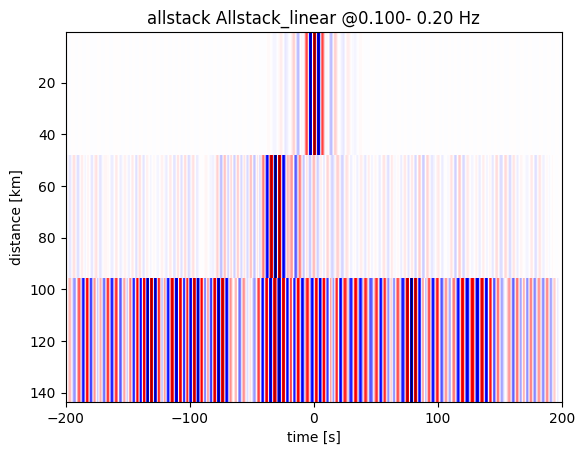

In [39]:
plot_all_moveout(stack_store, 'Allstack_linear', 0.1, 0.2, 'ZZ', 1)